In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from gensim.models import Word2Vec
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import joblib
from drain3.file_persistence import FilePersistence
from datetime import datetime, timedelta

In [12]:
output_file = "./ex1_set1.txt"

## Preprcessing and Drain Parser

In [ ]:
def normalize_log_line(line):
    line = re.sub(r"\d{4} \w{3}\s+\d{1,2} \d{2}:\d{2}:\d{2}", "<TIMESTAMP>", line)  # timestamp
    line = re.sub(r"\b(?:\d{1,3}\.){3}\d{1,3}\b", "<IP>", line)                # IP
    line = re.sub(r"(?:[0-9a-fA-F]{2}:){5}[0-9a-fA-F]{2}", "<MAC>", line)      # MAC
    line = re.sub(r"\[(Ext\d+|Router)\]", "<Device>", line) # Device
    return line

## drain parser
try :
    file_path = output_file
    with open(file_path, "r", encoding="utf-8") as f:
        log_lines = f.readlines()
        
    df = pd.read_csv('./parsed_logs.csv')

except:
    # 讀 log 並做 drain3 parsing 
    file_path = output_file
    with open(file_path, "r", encoding="utf-8") as f:
        log_lines = f.readlines()

    config = TemplateMinerConfig()

    config.drain_depth = 4
    config.drain_max_children = 100
    config.similarity_threshold = 0.5
    # config.extra_delimiters = "=:,()[]{}<>/"

    template_miner = TemplateMiner(persistence_handler=None, config=config)

    parsed_logs = []
    timestamp_pattern = re.compile(r"(\d{4} \w{3}\s+\d{1,2} \d{2}:\d{2}:\d{2})")


    with open("./output.txt", "w") as output: 
        for line in log_lines:
            
            # 抓 timestamp
            match = timestamp_pattern.search(line)
            if match:
                
                timestamp_str = match.group(1)
                # timestamp = pd.to_datetime(timestamp_str, format="%Y %b %d %H:%M:%S")
                timestamp = datetime.strptime(match.group(1), "%Y %b %d %H:%M:%S")
                
            else:
                timestamp = None  
            
            ## 進行前處理
            line = normalize_log_line(line)

            ## parsing
            res = template_miner.add_log_message(line)
            
            
            parsed_logs.append({
                "template_id": res["cluster_id"],
                "timestamp": timestamp,
                "template": res["template_mined"],
                "log": line.strip()
            })
            
            ## 將 parsing 後的結果寫到新的檔案
            output.write(f"{res['template_mined']}\n")


    df = pd.DataFrame(parsed_logs)
    df.to_csv("parsed_logs.csv", index=False)

df

,template_id,timestamp,template,log
0,1,2023-10-07 12:30:02,<Device> <TIMESTAMP> notice syslog-ng: Configu...,<Device> <TIMESTAMP> notice syslog-ng: Configu...
1,2,2023-10-07 12:30:02,<Device> <TIMESTAMP> notice syslog-ng: Configu...,<Device> <TIMESTAMP> notice syslog-ng: Configu...
2,3,2023-10-07 12:30:02,<Device> <TIMESTAMP> info dhcpd: [LDHCP] DHCPD...,<Device> <TIMESTAMP> info dhcpd: [LDHCP] DHCPD...
3,4,2023-10-07 12:30:02,<Device> <TIMESTAMP> info kernel: sh (27180): ...,<Device> <TIMESTAMP> info kernel: sh (27180): ...
4,1,2023-10-07 12:30:02,<Device> <TIMESTAMP> notice syslog-ng: Configu...,<Device> <TIMESTAMP> notice syslog-ng: Configu...
...,...,...,...,...
871003,16,2023-10-13 12:17:17,<Device> <TIMESTAMP> warning kernel: [FW] IPTA...,<Device> <TIMESTAMP> warning kernel: [FW] IPTA...
871004,269,2023-10-13 12:17:20,<Device> <TIMESTAMP> info arc_wifi: [WIFI.6][A...,<Device> <TIMESTAMP> info arc_wifi: [WIFI.6][A...
871005,269,2023-10-13 12:17:20,<Device> <TIMESTAMP> info arc_wifi: [WIFI.6][A...,<Device> <TIMESTAMP> info arc_wifi: [WIFI.6][A...
871006,179,2023-10-13 12:17:20,<Device> <TIMESTAMP> notice <*> <*> <*>,<Device> <TIMESTAMP> notice : [OWL.5][OWL 3794...


## Time series Analysis

In [14]:
from merlion.models.anomaly.dbl import DynamicBaseline, DynamicBaselineConfig
from merlion.transform.base import Identity
from merlion.utils import TimeSeries
from merlion.evaluate.anomaly import TSADMetric
from datetime import datetime

In [42]:
# 使用 IQR 或 Z-score
def detect_statistical_anomaly(ts, method='iqr'):
    if method == 'iqr':
        Q1 = ts.quantile(0.25)
        Q3 = ts.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return (ts < lower) | (ts > upper)
    
    elif method == 'zscore':
        mean = ts.mean()
        std = ts.std()
        z_scores = abs((ts - mean) / std)
        return z_scores > 3  # 3-sigma rule

# 找突然激增的 log templates
def detect_spike_anomaly(ts, spike_threshold=5):
    # 計算移動平均
    rolling_mean = ts.rolling(window=10, min_periods=1).mean()
    
    # 找出超過平均值 N 倍的點
    anomalies = ts > (rolling_mean * spike_threshold)
    return anomalies

from sklearn.ensemble import IsolationForest
import numpy as np

def detect_isolation_forest_anomaly(ts):
    # 準備特徵：原始值 + 移動平均 + 變化率
    features = pd.DataFrame({
        'value': ts,
        'rolling_mean': ts.rolling(10).mean(),
        'rolling_std': ts.rolling(10).std(),
        'diff': ts.diff(),
        'hour': ts.index.hour,  # 時間特徵
        'day_of_week': ts.index.dayofweek
    }).fillna(0)
    
    clf = IsolationForest(contamination=0.01, random_state=42)
    anomalies = clf.fit_predict(features)
    return anomalies == -1



In [97]:
# 設定時間為 index，並做 15 分鐘分組
df_time = df.copy()
df_time["timestamp"] = pd.to_datetime(df_time["timestamp"])  # 確保 timestamp 是 datetime 型態
df_time = df_time.set_index("timestamp")
df_time = df_time.sort_index()

counter_df = df_time.groupby([pd.Grouper(freq="5min"), "template_id"]).size().unstack(fill_value=0)

In [106]:
print("檢測到的 template 數量:",len(df_time['template_id'].unique()))

檢測到的 template 數量: 343


In [ ]:
results = []
normal = []
# for col in counter_df.columns:
for col in [i for i in range(31,60)]:
    
    ts = counter_df[[col]]
    
    # 篩掉樣本太少的 template
    if ts.sum().item() < 10:
        continue

    # Manual train/test split (30% train, 70% test)
    split_point = int(len(ts) * 0.3)
    train_df = ts.iloc[:split_point]
    test_df = ts#.iloc[split_point:]
    
    # Skip if test set is too small
    if len(test_df) < 2:
        continue

    # 製作 TimeSeries 格式
    train_ts = TimeSeries.from_pd(train_df)
    test_ts = TimeSeries.from_pd(test_df)

    # 初始化模型
    model = DynamicBaseline(
        config=DynamicBaselineConfig(
            
            wind_sz="3h"
        )
    )
    
    try:
        print(f"Template {col} - Train sum: {train_df.sum().item()}, Train len: {len(train_df)}")
        model.train(train_ts)
        # pred = model.get_anomaly_label(test_ts)
        pred = model.get_anomaly_label(test_ts)

        # 存入原時間序列中
        ts_pred = pred.to_pd()
        ts_pred.columns = ["score"]

        ## 正常的
        normal_pred = ts_pred[ts_pred["score"]<=0]
        normal_pred["template_group"] = col
        normal.append(normal_pred)


        # 只保留異常值（score > 0）
        result_pred = ts_pred[ts_pred["score"]>0]
        result_pred["template_group"] = col
        results.append(result_pred)
        

    except Exception as e:
        print(f"Error processing template {col}: {e}")
        continue


Template 31 - Train sum: 827, Train len: 515
Template 32 - Train sum: 245, Train len: 515
Template 33 - Train sum: 1261, Train len: 515
Template 34 - Train sum: 1342, Train len: 515
Template 35 - Train sum: 2163, Train len: 515
Template 36 - Train sum: 317, Train len: 515
Template 37 - Train sum: 185, Train len: 515
Template 38 - Train sum: 1193, Train len: 515
Template 39 - Train sum: 165, Train len: 515
Template 40 - Train sum: 165, Train len: 515
Template 41 - Train sum: 965, Train len: 515
Template 42 - Train sum: 1554, Train len: 515
Template 43 - Train sum: 8503, Train len: 515
Template 44 - Train sum: 8180, Train len: 515
Template 45 - Train sum: 1135, Train len: 515
Template 46 - Train sum: 1477, Train len: 515
Template 47 - Train sum: 1646, Train len: 515
Template 48 - Train sum: 495, Train len: 515
Template 49 - Train sum: 701, Train len: 515
Template 50 - Train sum: 1355, Train len: 515
Template 51 - Train sum: 1333, Train len: 515
Template 52 - Train sum: 2127, Train len: 5

In [109]:
counter_df

template_id,1,2,3,4,5,6,7,8,9,10,...,334,335,336,337,338,339,340,341,342,343
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-07 12:30:00,7,17,8,10,1,1,1,1,8,1,...,0,0,0,0,0,0,0,0,0,0
2023-10-07 12:35:00,0,10,0,5,1,1,1,1,8,1,...,0,0,0,0,0,0,0,0,0,0
2023-10-07 12:40:00,0,10,0,2,1,1,1,1,5,1,...,0,0,0,0,0,0,0,0,0,0
2023-10-07 12:45:00,0,9,8,1,1,1,1,1,5,1,...,0,0,0,0,0,0,0,0,0,0
2023-10-07 12:50:00,0,10,3,2,1,1,1,1,7,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13 11:55:00,0,13,0,8,1,1,1,1,6,1,...,1,0,0,0,0,0,0,0,0,0
2023-10-13 12:00:00,6,17,0,10,1,1,1,1,7,1,...,1,0,0,0,0,0,0,0,0,0
2023-10-13 12:05:00,0,11,0,6,1,1,1,1,6,1,...,0,0,0,0,0,0,0,0,0,0


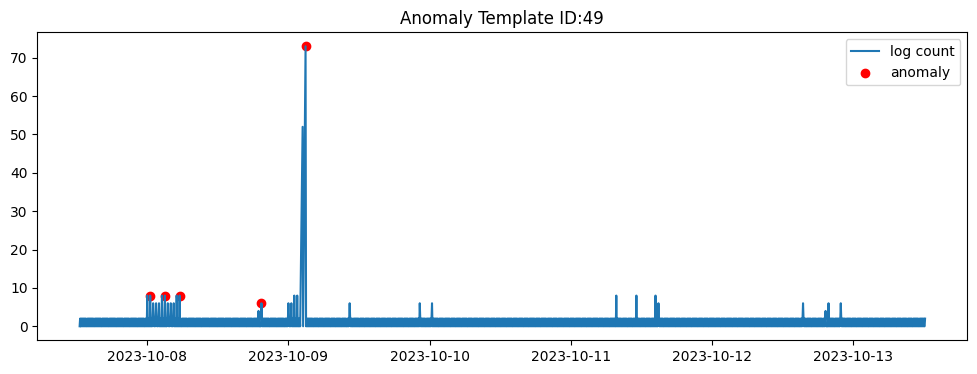

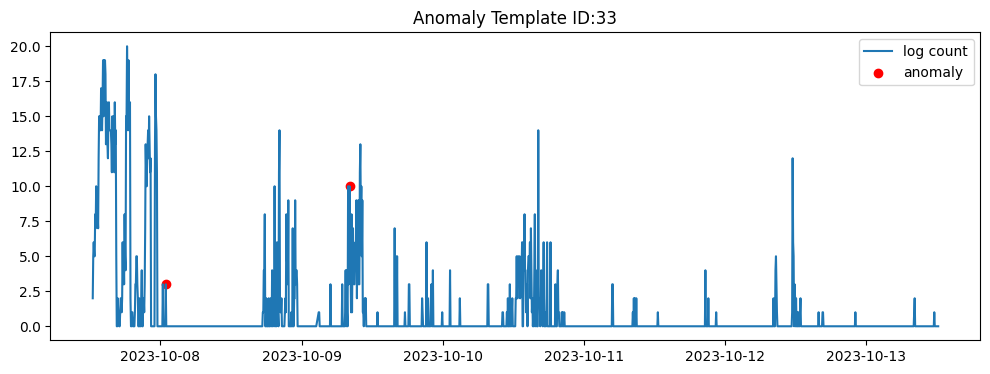

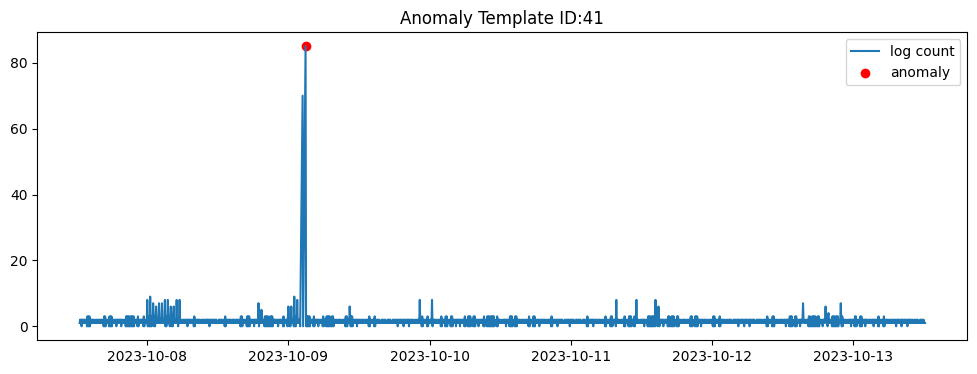

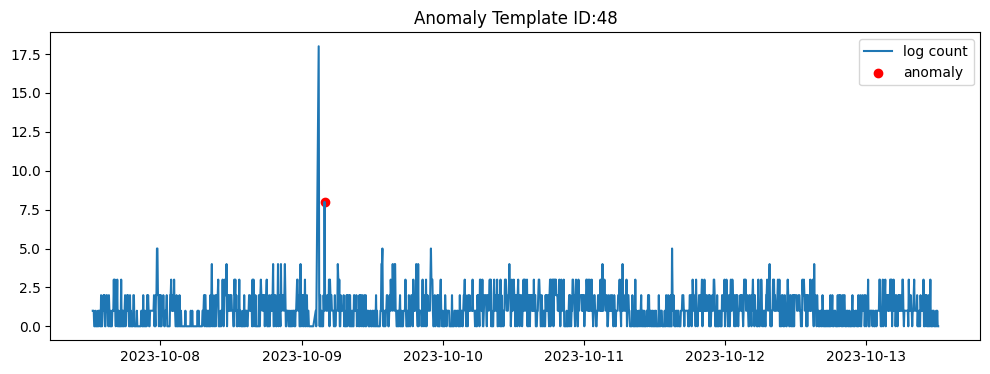

In [112]:
if results:
    
    anomalies = pd.concat(results)
    anomalies = anomalies.reset_index().rename(columns={"index": "time"})
    anomalies = anomalies.sort_values("time")

    # print(anomalies.head())

    # 畫圖（可選）
    for name in anomalies["template_group"].unique():
        sub_df = counter_df[[name]]
        sub_anom = anomalies[anomalies["template_group"] == name]
        
        plt.figure(figsize=(12, 4))
        
        plt.plot(sub_df.index, sub_df[name], label="log count")
        plt.scatter(sub_anom["time"], sub_df.loc[sub_anom["time"]][name],
                    color="red", label="anomaly")
        
        plt.title(f'Anomaly Template ID:{name}')
        plt.legend()
        plt.show()
        
else:
    print("No anomalies detected.")

## Vectorization (word2vec, TF-IDF)

In [ ]:
# # 將 template 向量化 

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD

# method = "word2vec"

# def vectorization(method, df):
    
#     if method == "word2vec":

#         templates = df["template"].apply(lambda x: x.split()).tolist()
#         w2v_model = Word2Vec(templates, vector_size=50, window=5, min_count=1, workers=2)

#         def avg_vector(words):
#             vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
#             if len(vecs) == 0:
#                 return np.zeros(w2v_model.vector_size)
#             return np.mean(vecs, axis=0)

#         df["template_vec"] = df["template"].apply(lambda x: avg_vector(x.split()))

#         X = np.vstack(df["template_vec"].values)
    
#     elif method == "tf-idf":
#         # 假設 df["template"] 是一個 log template 的文字欄位
#         corpus = df["template"].astype(str)

#         # 建立 TF-IDF 向量器
#         tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#         # 擬合並轉換所有 template（產出稀疏矩陣）
#         X_sparse = tfidf_vectorizer.fit_transform(corpus)
#         svd = TruncatedSVD(n_components=50, random_state=42)
#         X = svd.fit_transform(X_sparse)  # Dense matrix，但已大幅降維
        
#     else:
#         print("wrong method!")
#         X = []
        
#     return df, X

# df, X = vectorization(method, df)

## Isolation Forest

In [ ]:
# n_models = 5  # 建幾個模型

# # 用來存放每個模型的預測結果（1:正常, -1:異常）
# all_preds = np.zeros((len(X), n_models))

# for i in range(n_models):
#     iso_forest = IsolationForest(
#         contamination=0.01,
#         # n_estimators = 10,
#         # max_samples = "auto",
#         # max_features = 50,
#         random_state=42+i)
    
    
#     all_preds[:, i] = iso_forest.fit_predict(X)

# # 投票：同一筆資料異常票數 >= 門檻(這邊設一半以上)判為異常
# vote_threshold = n_models // 2 + 1
# vote_sum = (all_preds == -1).sum(axis=1)
# ensemble_labels = np.where(vote_sum >= vote_threshold, -1, 1)

# # 將 ensemble 結果加到 df
# df["iso_forest_ensemble_label"] = ensemble_labels

# # 篩選異常資料
# ensemble_anomalies = df[df["iso_forest_ensemble_label"] == -1]

# normal = df[df["iso_forest_ensemble_label"] == 1]

# ## 正常的
# print(f"共有 {len(normal)} 筆正常資料")

# print(f"異常資料共有 {len(ensemble_anomalies)} 筆")
# print("異常資料範例：")
# ensemble_anomalies[["template", "iso_forest_ensemble_label"]].head()


共有 864559 筆正常資料
異常資料共有 6449 筆
異常資料範例：


,template,iso_forest_ensemble_label
83,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,-1
84,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,-1
111,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,-1
144,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,-1
307,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,-1


In [ ]:
# df[df['template_id']==7].to_csv('template_id_equals_to_7.csv', index=False)

In [ ]:
# import pandas as pd

# ## 異常 log 的列聯表 

# # 建立基本列聯表 (正常 / 異常 計數)
# contingency_table = pd.crosstab(df["template_id"], df["iso_forest_ensemble_label"])
# contingency_table.columns = ["Anomaly (-1)", "Normal (1)"]
# contingency_table = contingency_table.reset_index()

# # 把 template 對應上來（取每個 template_id 的第一個樣板）
# template_map = df.groupby("template_id")["template"].first().reset_index()

# # 合併 template 欄位
# contingency_table = contingency_table.merge(template_map, on="template_id", how="left")

# # 加總與比例
# contingency_table["total"] = contingency_table["Anomaly (-1)"] + contingency_table["Normal (1)"]
# contingency_table["anomaly_ratio"] = contingency_table["Anomaly (-1)"] / contingency_table["total"]

# # 排序：異常比例最高的在前面
# contingency_table = contingency_table.sort_values(by="Anomaly (-1)", ascending=False)

# # 顯示前幾筆結果
# pd.set_option("display.max_colwidth", 100)  # 若 template 太長可調整寬度
# contingency_table.to_csv("contingency_table.csv", index=False)
# contingency_table.head()

,template_id,Anomaly (-1),Normal (1),template,total,anomaly_ratio
25,26,6449,0,<Device> <TIMESTAMP> info dev_notifid: [DEVNOTIFY.6]Device(<MAC>) seems not alive and not in dev...,6449,1.0
0,1,0,1876,"<Device> <TIMESTAMP> notice syslog-ng: Configuration reload request received, reloading configur...",1876,0.0
226,227,0,1,<Device> <TIMESTAMP> warning kernel: [FW] IPTABLES [Pkt_Illegal] IN=br-lan OUT= MAC=<MAC>:<MAC>:...,1,0.0
233,234,0,4,<Device> <TIMESTAMP> err arc_appapi.sh: 2023-10-09 02:56:38: (mod_openssl.c.2635) SSL: ssl.use-s...,4,0.0
232,233,0,2,"<Device> <TIMESTAMP> info arc_appapi.sh: certificate locate at /dev/mmcblk0p26, total size is 20...",2,0.0


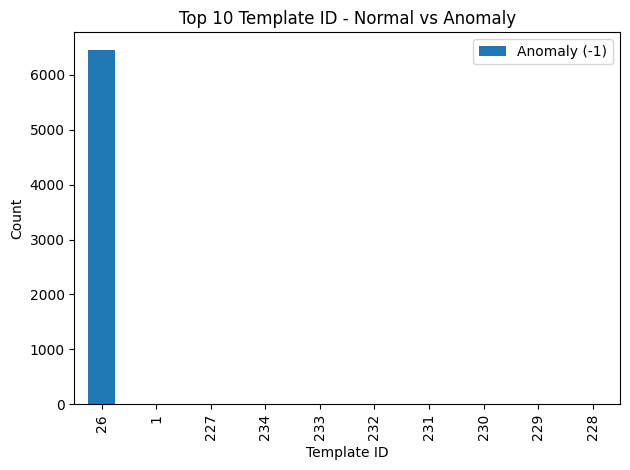

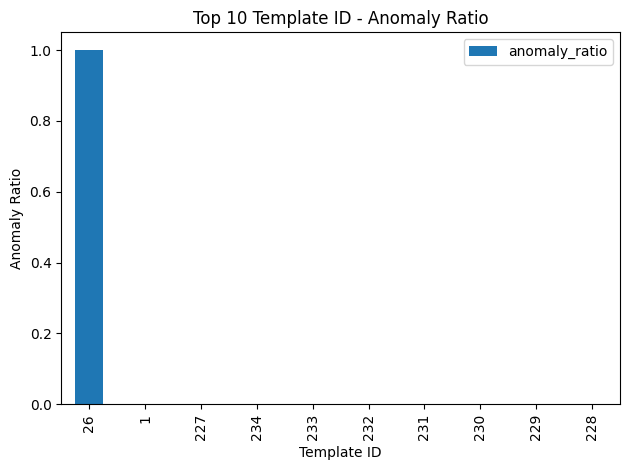

In [ ]:
# import matplotlib.pyplot as plt

# ## 異常 log 數量
# top_k = 10  # 看前10個最異常的 template_id
# top_templates = contingency_table.head(top_k)

# top_templates.plot(x="template_id", y=["Anomaly (-1)"], kind="bar", stacked=False)
# plt.title("Top 10 Template ID - Normal vs Anomaly")
# plt.xlabel("Template ID")
# plt.ylabel("Count")
# plt.legend()
# plt.tight_layout()
# plt.show()

# ## 異常比例
# top_templates.plot(x="template_id", y="anomaly_ratio", kind="bar")
# plt.title("Top 10 Template ID - Anomaly Ratio")
# plt.xlabel("Template ID")
# plt.ylabel("Anomaly Ratio")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# print(f"總共有 {df['template_id'].max()} 個 patterns")
# print("-"*40)
# # print("pattern 編號如下：")
# # print("-"*40)
# # df['template_id'].unique() 

總共有 343 個 patterns


In [ ]:
# ## Isolation Forest 找出的異常 log 資料

# print("Isolation Forest 找出的異常 log:")
# print("-"*40)

# for i, line in enumerate(log_lines):
#     if i in ensemble_anomalies.index:
#         print(line)

Isolation Forest 找出的異常 log:
----------------------------------------
[Router] 2023 Oct  7 12:30:24 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:30:24 info dev_notifid: [DEVNOTIFY.6]Device(d8:9c:67:c0:75:5d) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:31:24 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:32:24 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:34:25 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:35:24 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and not in devnotifid, probe it.

[Router] 2023 Oct  7 12:36:24 info dev_notifid: [DEVNOTIFY.6]Device(34:86:5d:51:80:e0) seems not alive and no

## DBSCAN

In [ ]:
# ## DBSCAN 分群
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import hdbscan


# # 標準化後降維（避免高維度效能瓶頸）
# X_scaled = StandardScaler().fit_transform(X)
# X_pca = PCA(n_components=10, random_state=42).fit_transform(X_scaled)

# # 使用 HDBSCAN 建群，產生 outlier score 
# clusterer = hdbscan.HDBSCAN(min_cluster_size=30, prediction_data=True)


# df["hdbscan_label"] = clusterer.fit_predict(X_pca)
# df["hdbscan_outlier_score"] = clusterer.outlier_scores_

# # 將異常分數高的視為異常 log 
# threshold = 0.8  # 通常介於 0.7~0.9
# df["is_anomaly"] = df["hdbscan_outlier_score"] > threshold

# dbscan_anomaly = df[df['is_anomaly']==True]

# # 檢視結果
# print("發現異常 log 數量：", df["is_anomaly"].sum())
# dbscan_anomaly

In [ ]:
# len(df['hdbscan_label'].unique())

In [ ]:
# print("hdbscan 找出的 outlier:")
# print("-"*40)

# for i, line in enumerate(log_lines):
#     if i in dbscan_anomaly.index:
#         print(line)

In [ ]:
# # 建立列聯表：template_id vs is_anomaly (True / False)
# hdbscan_table = pd.crosstab(df["template_id"], df["is_anomaly"])
# hdbscan_table = hdbscan_table.rename(columns={False: "Normal", True: "Anomaly"}).reset_index()

# # 合併 template 樣板
# template_map = df.groupby("template_id")["template"].first().reset_index()
# hdbscan_table = hdbscan_table.merge(template_map, on="template_id", how="left")

# # 加總與異常比例
# hdbscan_table["total"] = hdbscan_table["Normal"] + hdbscan_table["Anomaly"]
# hdbscan_table["anomaly_ratio"] = hdbscan_table["Anomaly"] / hdbscan_table["total"]

# # 排序顯示
# hdbscan_table = hdbscan_table.sort_values(by="anomaly_ratio", ascending=False)
# hdbscan_table.to_csv("hdbscan_anomaly_result.csv", index=False)
# hdbscan_table.head(10)

In [ ]:
# from sklearn.metrics.pairwise import cosine_distances

# tid = 295  # 換成任意一個你想看 template_id
# vecs = np.vstack(df[df['template_id'] == tid]['template_vec'].values)
# distances = cosine_distances(vecs)

# plt.imshow(distances, cmap="viridis")
# plt.title(f"Cosine distance matrix for template_id={tid}")
# plt.colorbar(label="Distance")
# plt.show()
# vecs

In [ ]:
# df[df['template_id'] == tid]

In [ ]:
# for i in df[df['template_id'] == tid]['template']:
#     print(i)

In [ ]:
# import umap.umap_ as umap

# # UMAP 是近似線性，適合百萬筆資料
# umap_2d = umap.UMAP(n_components=2, random_state=42)
# X_2d_umap = umap_2d.fit_transform(X_pca)

# plt.figure(figsize=(10, 7))
# plt.title("HDBSCAN Clusters (UMAP 2D)")
# plt.scatter(
#     X_2d_umap[:, 0], X_2d_umap[:, 1], 
#     c=df["hdbscan_label"], 
#     cmap="tab10", s=3, alpha=0.6
# )
# plt.colorbar(label="Cluster Label")
# plt.show()

In [ ]:



# model_dir = "./"
# os.makedirs(model_dir, exist_ok=True)

# # # 儲存 Word2Vec
# # w2v_model.save(os.path.join(model_dir, "word2vec.model"))

# # 儲存 Isolation Forest
# joblib.dump(iso_forest, os.path.join(model_dir, "isolation_forest.pkl"))

# # Drain3 儲存用的 JSON
# persistence = FilePersistence(os.path.join(model_dir, "drain3_state.json"))

